**Sentiment Analysis:**
computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.

## About DataSet

**This data originally came from Crowdflower's Data for Everyone library As the original source says,**

**We looked through tens of thousands of tweets about the early August GOP debate in Ohio and asked contributors to do both sentiment analysis and data categorization. Contributors were asked if the tweet was relevant, which candidate was mentioned, what subject was mentioned, and then what the sentiment was for a given tweet. We've removed the non-relevant messages from the uploaded dataset.**

**The data we're providing on Kaggle is a slightly reformatted version of the original source**

### Load Important libs

In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

Only keeping the necessary columns.

### Exploring Data

In [42]:
data = pd.read_csv('Sentiment.csv')
data = data[['text','sentiment']]

In [43]:
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


### PreProcessing 

So,Next, I am dropping the 'Neutral' sentiments as my goal was to only differentiate positive and negative tweets. After that, I am filtering the tweets so only valid texts and words remain.  Then, I define the number of max features as 2000 and use Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input.

In [44]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

4472
16986


C:\Users\dell\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'sentiments'}, xlabel='sentiment', ylabel='count'>

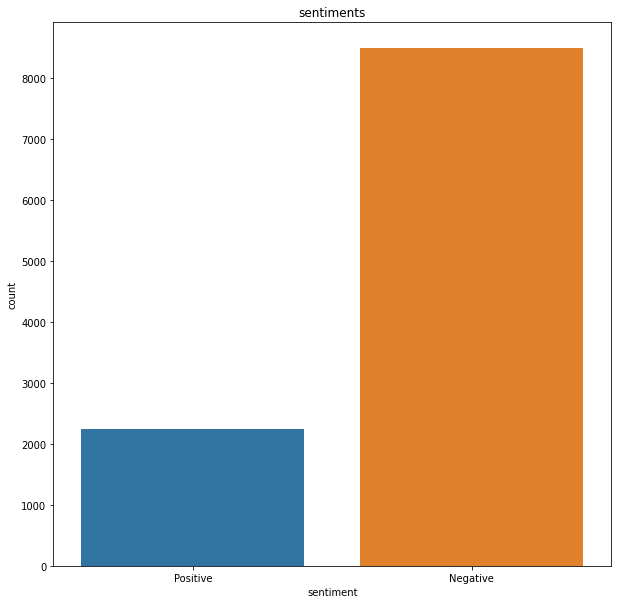

In [45]:
plt.figure(figsize=(10,10))
plt.title("sentiments")
sns.countplot(data['sentiment'])

In [47]:
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

# Modelling

Next, I compose the LSTM Network. Note that **embed_dim**, **lstm_out**, **batch_size**, **droupout_x** variables are hyperparameters, their values are somehow intuitive, can be and must be played with in order to achieve good results. Please also note that I am using softmax as activation function. The reason is that our Network is using categorical crossentropy, and softmax is just the right activation method for that.

In [48]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim ,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 128)           256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 28, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


Hereby I declare the train and test dataset.

In [50]:
y = pd.get_dummies(data['sentiment']).values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7188, 28) (7188, 2)
(3541, 28) (3541, 2)


In [52]:
batch_size = 32
model.fit(X_train, y_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
225/225 - 39s - loss: 0.4344 - accuracy: 0.8182 - 39s/epoch - 172ms/step
Epoch 2/10
225/225 - 33s - loss: 0.3195 - accuracy: 0.8671 - 33s/epoch - 148ms/step
Epoch 3/10
225/225 - 38s - loss: 0.2745 - accuracy: 0.8845 - 38s/epoch - 171ms/step
Epoch 4/10
225/225 - 31s - loss: 0.2470 - accuracy: 0.8986 - 31s/epoch - 136ms/step
Epoch 5/10
225/225 - 28s - loss: 0.2143 - accuracy: 0.9121 - 28s/epoch - 125ms/step
Epoch 6/10
225/225 - 27s - loss: 0.1952 - accuracy: 0.9204 - 27s/epoch - 122ms/step
Epoch 7/10
225/225 - 27s - loss: 0.1750 - accuracy: 0.9311 - 27s/epoch - 121ms/step
Epoch 8/10
225/225 - 29s - loss: 0.1548 - accuracy: 0.9360 - 29s/epoch - 129ms/step
Epoch 9/10
225/225 - 29s - loss: 0.1424 - accuracy: 0.9412 - 29s/epoch - 127ms/step
Epoch 10/10
225/225 - 28s - loss: 0.1304 - accuracy: 0.9470 - 28s/epoch - 125ms/step


0.947 % accuracy 
**Note: If we increas number of epochs ,the accuracy increases**

Extracting a validation set, and measuring score and accuracy.

In [ ]:
validation_size = 1500

X_validate = X_test[-validation_size:]
y_validate = y_test[-validation_size:]
X_test = X_test[:-validation_size]
y_test = y_test[:-validation_size]
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

Finally measuring the number of correct guesses.  It is clear that finding negative tweets goes very well for the Network but deciding whether is positive is not really. My educated guess here is that the positive training set is dramatically smaller than the negative, hence the "bad" results for positive tweets.

In [ ]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(y_validate[x]):
        if np.argmax(y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

As it was requested by the crowd, I extended the kernel with a prediction example, and also updated the API calls to Keras 2.0. Please note that the network performs poorly. Its because the training data is very unbalanced (pos: 4472, neg: 16986), you should get more data, use other dataset, use pre-trained model, or weight classes to achieve reliable predictions.

I have created this kernel when I knew much less about LSTM & ML. It is a really basic, beginner level kernel, yet it had a huge audience in the past year. I had a lot of private questions and requests regarding this notebook and I tried my best to help and answer them . In the future I am not planning to answer custom questions and support/enhance this kernel in any ways. Thank you my folks :)

In [72]:
twt = ['F!!!!']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
1/1 - 0s - 40ms/epoch - 40ms/step
negative


# By : Mahmoud Abdel-Moaty 